In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import seaborn as sns
from scipy import interpolate

# map functions
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# ordinary least squares
from statsmodels.formula.api import ols

# scikit-learn machine learning
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import normalize

# for graphing decision trees
import graphviz 
from sklearn.tree import export_graphviz

plt.style.use('seaborn-colorblind')

# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
# compound annual growth rate

def cagr(first, last, periods=1): 
    if first == 0:
        return None
    x = ((last/first) ** (1/periods) - 1 ) * 100
    if x > 30:  # arbitrary earnings growth cap. Tweak if needed.
        return None
    if x < 0:
        return None
    return x

In [3]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


In [6]:
# pivot earnings data to show annual earnings by name:
growth = pd.pivot_table(earnings, columns='year', index=['name'], values='regular')\
                    .reset_index()\
                    .apply(pd.to_numeric, errors='ignore')

# calculate CAGR for all available years:
years = (earnings.year.unique())
for previous, following in zip(years, years[1:]):
    growth['yoy' + str(following)] = growth.apply(lambda x: None \
                                                  if (x[previous] or x[following]) < 20000 \
                                                  else cagr(x[previous], x[following]), axis=1)

# drop names with no qualified CAGR entries:
c = growth.iloc[0:, -(len(years)-1):].columns
growth = growth.dropna(subset=c, how='all')

# merge with 'titles_clean' (both first and last) and 'dept_clean' (only the most recent):
titles = earnings.groupby('name')[['title_clean', 'dept_clean']]\
                 .agg({'title_clean':['first', 'last'], 'dept_clean':'last'})\
                 .reset_index()

# avoid multiindex issues:
titles.columns = ['_'.join(tup).rstrip('_') for tup in titles.columns.values]

# merge dataframes:
growth_title = growth.merge(titles, how='left', on='name')
growth_title.head(10)

,name,2011,2012,2013,2014,2015,2016,2017,yoy2012,yoy2013,yoy2014,yoy2015,yoy2016,yoy2017,title_clean_first,title_clean_last,dept_clean_last
0,"Abadi,Kidani A",33065.38,34554.41,37588.30,40303.47,44006.26,46291.98,48176.33,4.503290,8.780037,7.223445,9.187273,5.194079,4.070576,Property Officer (Asn),Admin Asst,Assessing Department
1,"Abasciano,Joseph",68181.24,69432.97,66673.45,19469.90,-886.20,6933.66,86806.50,1.835886,NaN,NaN,NaN,NaN,NaN,Police Officer,Police Officer,Boston Police Department
2,"Abban,Christopher John",69846.85,88006.86,87210.42,93036.25,101468.29,103442.22,105451.53,25.999755,NaN,6.680199,9.063177,1.945366,1.942447,Fire Fighter,Fire Fighter,Boston Fire Department
3,"Abbate-Vaughn,Jorgelina",NaN,NaN,NaN,NaN,42919.31,84410.28,87333.21,NaN,NaN,NaN,NaN,NaN,3.462765,Teacher,Teacher,Boston Public Schools
4,"Abberton,James P",NaN,NaN,NaN,21373.29,39768.17,41449.16,43722.85,NaN,NaN,NaN,NaN,4.226973,5.485491,Maint Mech (Carpenter)##,Maint Mech (Carpenter)##,Public Works Department
5,"Abbott,Erin Elizabeth",NaN,NaN,NaN,NaN,NaN,80413.68,83750.16,NaN,NaN,NaN,NaN,NaN,4.149145,Teacher,Teacher,Boston Public Schools
6,"Abbott,John R.",85562.10,85842.76,88440.27,91218.40,98938.55,99264.10,96014.39,0.328019,3.025893,3.141250,8.463369,0.329043,NaN,Teacher,Teacher,Boston Public Schools
7,"Abdal-Khallaq,Musiri Kari",18104.00,62582.65,67472.70,73215.89,84249.74,93142.59,93017.63,NaN,7.813747,8.511872,15.070294,10.555344,NaN,Teacher,Teacher,Boston Public Schools
8,"Abdal-Khallaq,Naima",82448.18,88691.90,94921.39,95892.61,88539.63,105500.20,102051.14,7.572902,7.023742,1.023183,NaN,19.155908,NaN,Teacher,Teacher,Boston Public Schools
9,"Abdalkhallaq,Amira N.",85935.70,90344.79,100295.63,101474.77,106848.84,105500.20,102051.14,5.130685,11.014293,1.175664,5.295967,NaN,NaN,Teacher,Teacher,Boston Public Schools


In [80]:
# get top 10 titles by number of employees

titles_top10 = growth_title[growth_title['title_clean_first'] == growth_title['title_clean_last']]\
                .groupby('title_clean_first')\
                .agg('size')\
                .sort_values(ascending=False)\
                .index[:10]

# keep only growth rate columns ('yoy...') and top 10 title rows

payraise = growth_title.iloc[:, len(years)+1:(len(years)*2)+1]
payraise = payraise[payraise['title_clean_first'].isin(titles_top10)]

# calculate means and mean of means

payraise = payraise.set_index('title_clean_first')
payraise['mean'] = payraise.stack().groupby(level=0).mean()
payraise  = payraise.groupby(payraise.index).agg('mean')
payraise = payraise[::-1]

payraise

,yoy2012,yoy2013,yoy2014,yoy2015,yoy2016,yoy2017,mean
title_clean_first,,,,,,,
Teacher,4.312687,6.296547,6.105167,9.741033,5.204945,5.169551,6.380647
Police Sergeant,2.499536,2.721173,8.638750,11.345737,2.511952,1.325387,5.570049
Police Officer,2.896359,3.090682,15.436056,8.175358,3.774145,6.949488,7.037386
Police Detective,1.033808,1.326743,2.085320,3.388821,19.006175,5.904420,5.557301
Parking Meter Supervisor,5.608893,6.451053,6.450025,7.343637,4.946970,4.846726,5.979249
Paraprofessional,6.146410,8.783335,6.382011,11.359045,7.510372,6.821328,8.159790
Librarian,3.025612,4.103047,6.776937,8.900005,4.237243,2.508856,5.125020
Fire Lieutenant,5.198096,4.794028,7.617255,11.235508,5.219886,5.531927,6.838688
Fire Fighter,6.472605,6.560067,8.641175,12.953381,6.270763,6.621981,8.103950


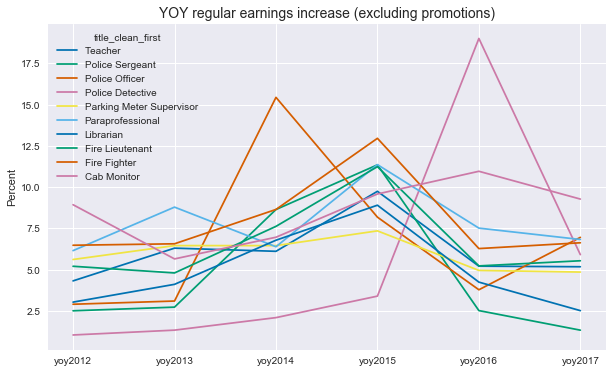

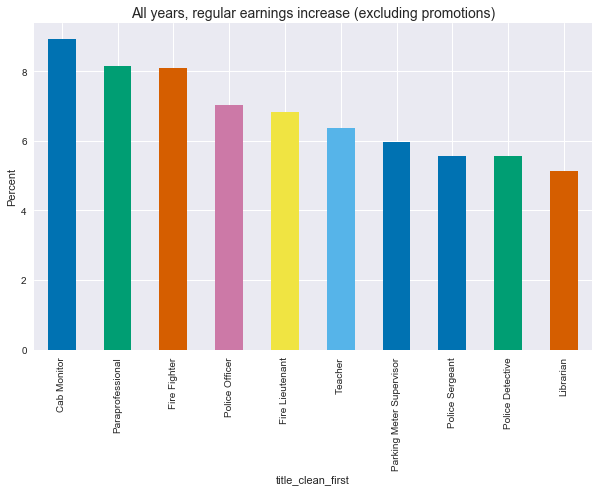

In [79]:
# pay raises by year

 
# plot
ax = payraise.drop(columns='mean').T.plot(figsize=(10,6), xticks=[0,1,2,3,4,5])
ax.set_ylabel('Percent')
ax.set_title('YOY regular earnings increase (excluding promotions)', fontsize=14)
plt.show()

# pay raises - all years
ax = payraise.sort_values('mean', ascending=False).iloc[:,-1].T.plot(kind='bar',figsize=(10,6), xticks=[0,1,2,3,4,5])
ax.set_ylabel('Percent')
ax.set_title('All years, regular earnings increase (excluding promotions)', fontsize=14)
plt.show()


In [3]:
# extract 10 largest departments
departments = earnings[earnings['year'] == 2017].groupby('dept_clean')['name'].agg(np.size).nlargest(10)
dept_list = departments.index
departments = earnings[(earnings['dept_clean'].isin(dept_list)) & (earnings['year'] == 2017)] \
                    .rename(index=str, columns={'dept_clean': 'Department'})  # for plot legend

In [4]:
# extract 10 most common job titles
titles = earnings[earnings['year'] == 2017].groupby('title_clean')['name'].agg(np.size).nlargest(10)
titles_list = titles.index
titles = earnings[(earnings['title_clean'].isin(titles_list)) & (earnings['year'] == 2017)] \
                .rename(index=str, columns={'title_clean': 'Job Title'})  # for plot legend

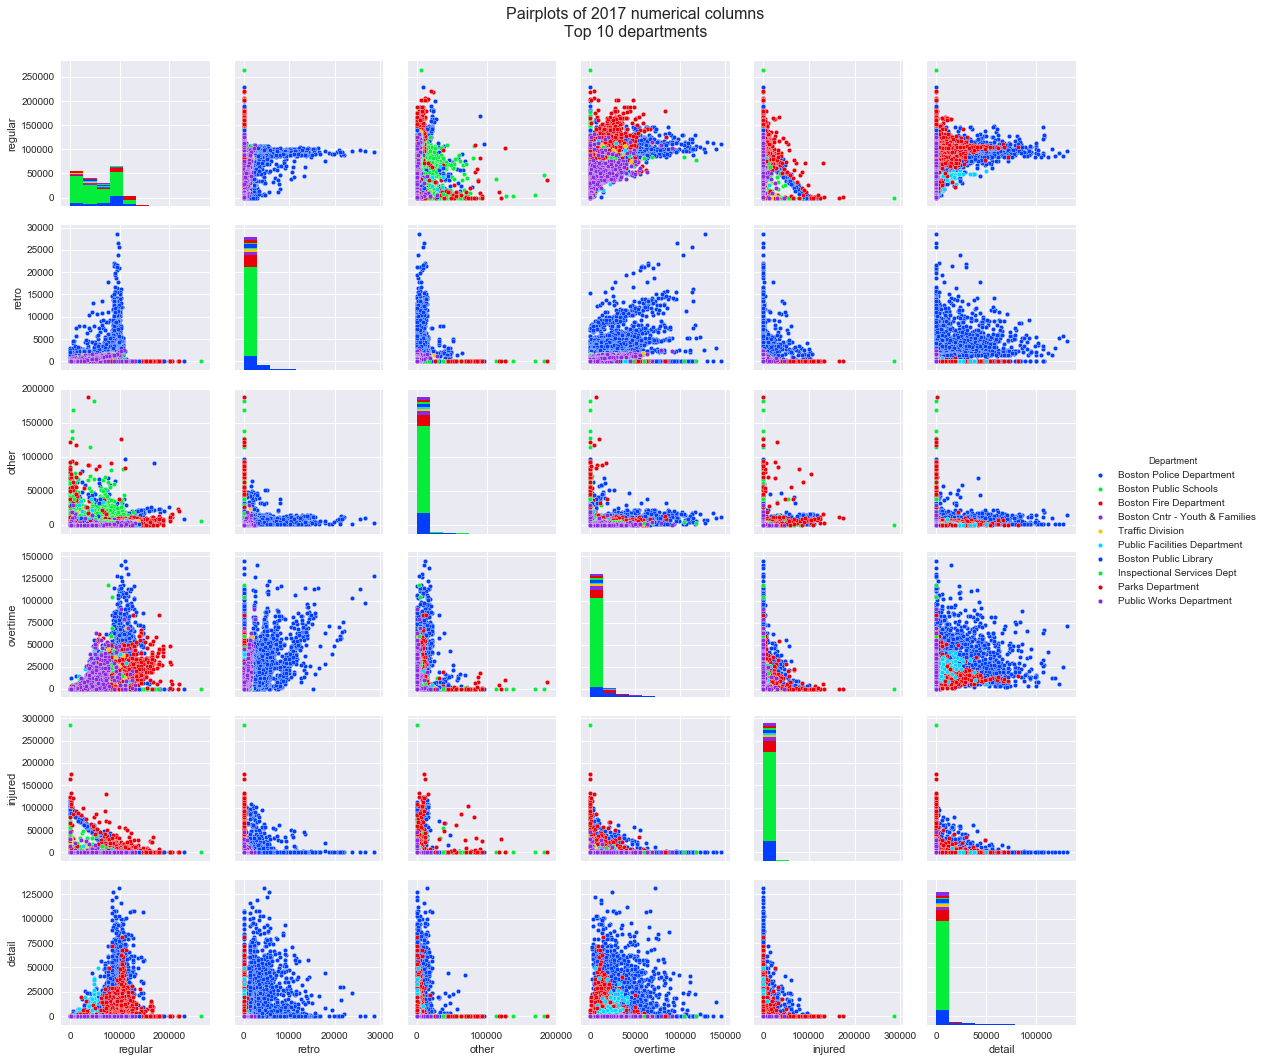

In [5]:
usecols = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail']
g = sns.pairplot(departments, hue='Department', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of 2017 numerical columns\nTop 10 departments', fontsize=16)
plt.show()

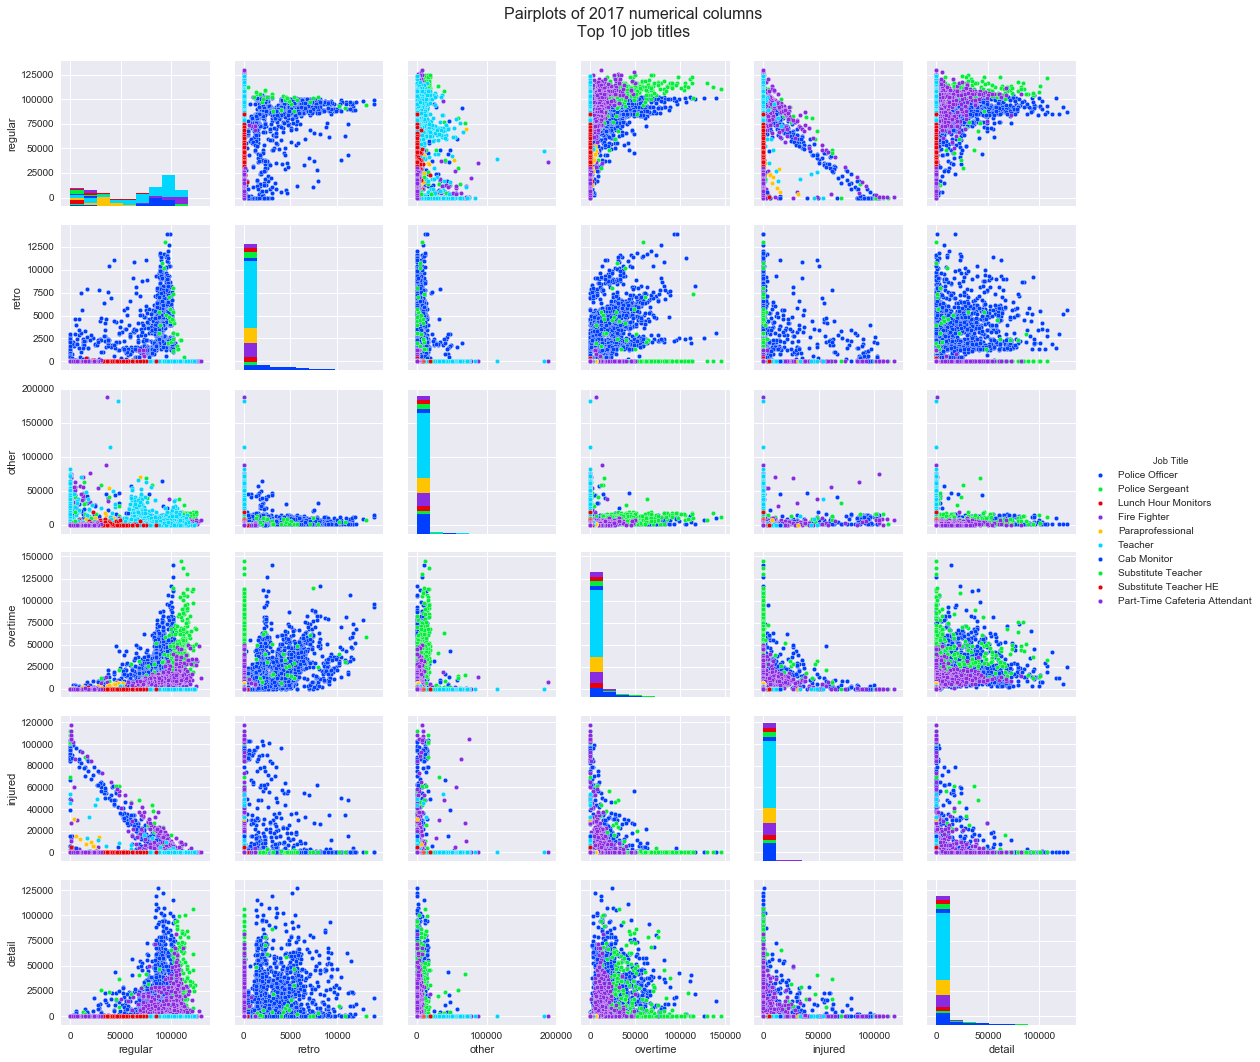

In [6]:
g = sns.pairplot(titles, hue='Job Title', vars=usecols, plot_kws={"s": 20}, palette="bright")
g.fig.subplots_adjust(top=.93)
g.fig.suptitle('Pairplots of 2017 numerical columns\nTop 10 job titles', fontsize=16)
plt.show()

The paired scatter plots above show the relationship between all of the numerical columns in the dataframe with exception of "Quinn" which is an education incentive specific to the police department, and "Total", which is the sum of the numerical columns. 

A few general observations follow:

- The charts are dominated by the highest paid employees: Police and fire fighters. 
- "Retro" payments are almost exclusive to the police department.
- "Overtime" is primarily for middle income employees. Salaried employees don't usually get overtime pay and lower income employees get overtime pay proportional to their income.
- "Injured" pay is mostly for police and fire fighters, and it appears to replace "regular" pay.
- "Detail" and "overtime" scatter plots have similar shapes and may possibly be alternative categories for similar compensation.

2017 number of employees: 511


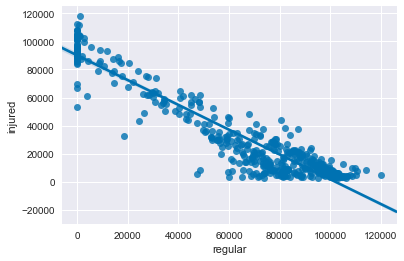

In [7]:
""" 
dataset focused on 'normal' income levels with both regular and injured earnings types
"""
# injured = titles[((titles.injured > 40000) | (titles.regular > 40000)) & ((titles.injured > 3000) & (titles.regular > 3000))]
injured = titles[((titles.injured + titles.regular) > 50000)  & (titles.injured > 3000)]
print('2017 number of employees:', injured.shape[0])
sns.regplot(x='regular', y='injured', data=injured)
plt.show()

In [8]:
m = ols('regular ~ injured',injured).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                regular   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     4328.
Date:                Tue, 03 Apr 2018   Prob (F-statistic):          5.16e-251
Time:                        16:13:43   Log-Likelihood:                -5491.9
No. Observations:                 511   AIC:                         1.099e+04
Df Residuals:                     509   BIC:                         1.100e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.828e+04    693.360    141.740      0.0

# Can we distinguish between police officers and fire fighters?

- extract police and fire fighter titles for 2017
- run KMeans clustering on the numeric earnings data
- compare the clustering labels with actual labels

In [9]:
# police officers & fire fighters in 2017
pol_ff = earnings[earnings['title_clean'].isin(['Police Officer', 'Fire Fighter']) & (earnings.year == 2017)]
print('Number of observations:', pol_ff.shape[0])

Number of observations: 2740


In [10]:
usecols = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail'] # numeric columns
pol_ff_num = pol_ff[usecols]
pol = len(pol_ff[pol_ff.title_clean == 'Police Officer'])
pol

1616

In [46]:
# KMeans
pol_ff_num = normalize(pol_ff_num)
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(pol_ff_num)

pol_ff['label'] = labels

correct = len(pol_ff[(pol_ff.title_clean == 'Police Officer') & (pol_ff.label == 0)])
pol = len(pol_ff[pol_ff.title_clean == 'Police Officer'])
print('KMeans clustering of 2 clusters correctly labeled {0:.2f}% of police officers'.format(correct/pol * 100))

KMeans clustering of 2 clusters correctly labeled 91.15% of police officers


C:\Users\rujjn\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


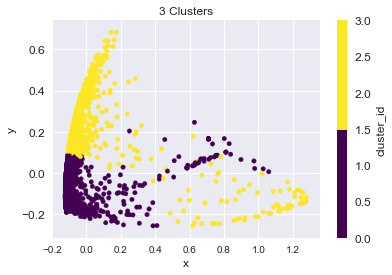

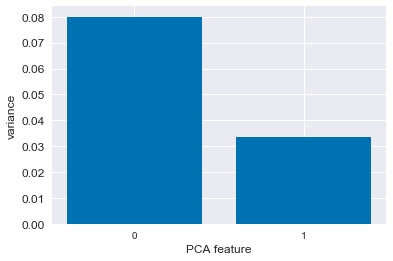

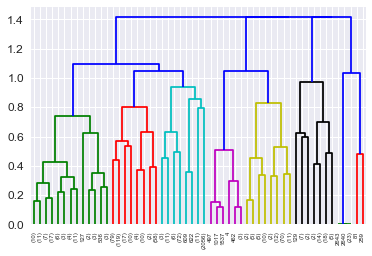

In [44]:
# reduce to two dimensions
pca = PCA(n_components=2)

components = pca.fit_transform(pol_ff_num)


# add to data frame and plot
df_pca = pd.DataFrame({'title': pol_ff.title_clean, 'cluster_id': labels, 'x': components[:,0], 'y': components[:,1]})\
            .plot.scatter('x', 'y', c='cluster_id', cmap=plt.cm.get_cmap('viridis', 2), sharex=False, title='3 Clusters')

plt.show()

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

mergings = linkage(pol_ff_num, method='complete')
dendrogram(mergings, p=5, truncate_mode='level')
plt.show()

In [13]:
# data for classifiers:
# police officers & fire fighters in 2017
pol_ff = earnings[earnings['title_clean'].isin(['Police Officer', 'Fire Fighter']) & (earnings.year == 2017)]
print('Number of observations:', pol_ff.shape[0])
usecols = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail']
X = pol_ff[usecols] 
y = pd.factorize(pol_ff['title_clean'])[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

Number of observations: 2740


In [14]:
# logistic regression:
lrc = LogisticRegression()
lrc.fit(X_train, y_train)
cv_scores = cross_val_score(lrc, X_train, y_train, cv=10, scoring='roc_auc')
print('mean cv score:', np.mean(cv_scores), '\n')

# hyper-parameter tuning
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}

gs = GridSearchCV(lrc, param_grid, cv=10)
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)
cv_scores = cross_val_score(lrc, X, y, cv=10, scoring='roc_auc')
print('mean cv score:', np.mean(cv_scores), '\n')


mean cv score: 0.9968289086313922 

{'C': 0.001}
0.9443430656934306
mean cv score: 0.9969411121188246 



In [15]:
# train a decision tree classifier:
dtc = DecisionTreeClassifier(max_depth=2, min_samples_split=100)
dtc.fit(X_train, y_train)

# metrics:
print('Score:', dtc.score(X_test, y_test))
cm = metrics.confusion_matrix(y, dtc.predict(X))
print('Confusion matrix:', '\n', cm)
accuracy = (cm[0][0] + cm[1][1])/pol_ff.shape[0]
a2 = metrics.accuracy_score(dtc.predict(X_test), y_test)
print('Accuracy:', accuracy, '\n', a2)
cv_scores = cross_val_score(dtc, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')


Score: 0.9872262773722628
Confusion matrix: 
 [[1587   29]
 [   7 1117]]
Accuracy: 0.9868613138686131 
 0.9872262773722628
mean cv score: 0.9864962045254015 



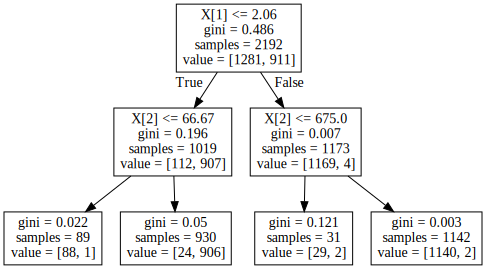

In [16]:
dot_data = export_graphviz(dtc, out_file=None) 
graph = graphviz.Source(dot_data) 
graph


In [17]:
# train a random forest classifier:
rfc = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=20)
rfc.fit(X_train, y_train)

# metrics:
print('Score:', rfc.score(X_test, y_test))
cm = metrics.confusion_matrix(y, rfc.predict(X))
print('Confusion matrix:', '\n', cm)
accuracy = (cm[0][0] + cm[1][1])/pol_ff.shape[0]
a2 = metrics.accuracy_score(rfc.predict(X_test), y_test)
print('Accuracy:', accuracy, '\n', a2)
cv_scores = cross_val_score(rfc, X, y, cv=10)
print('mean cv score:', np.mean(cv_scores), '\n')

# generate feature importances and standard deviations dataframe
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
importances = pd.DataFrame([X_test.columns, rfc.feature_importances_, std])\
                .T.rename(columns={0:'feature', 1:'importance', 2:'std'})\
                .sort_values(by='importance', ascending=False)
print(importances)

Score: 0.9963503649635036
Confusion matrix: 
 [[1606   10]
 [   4 1120]]
Accuracy: 0.9948905109489051 
 0.9963503649635036
mean cv score: 0.992693987277929 

    feature importance        std
1     retro   0.471723   0.282517
0   regular   0.239941   0.210422
2     other   0.172262   0.130436
3  overtime  0.0817368  0.0875291
5    detail  0.0172802  0.0256147
4   injured  0.0170574  0.0224329


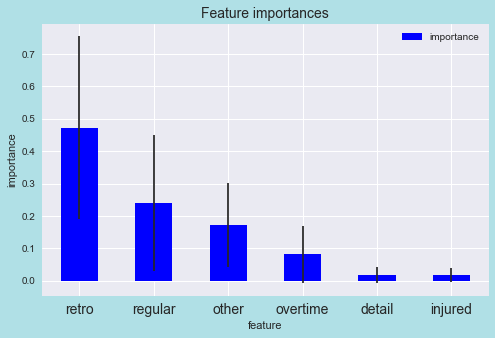

In [18]:
# Plot the feature importances of the forest
fig, ax = plt.subplots(facecolor='powderblue', figsize=(8,5))
importances.plot('feature', 'importance', kind='bar', color="b", yerr='std', align="center", ax=ax)
plt.title('Feature importances', fontsize=14)
plt.ylabel('importance')
ax.set_xticklabels(importances['feature'], rotation=0, fontsize=14)
plt.show()

In [119]:
df = pd.DataFrame(np.arange(20).reshape(10, -1),
                  [['a', 'a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'd'],
                   ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']],
                  ['X', 'Y'])
df

X   Y
a a   0   1
  b   2   3
  c   4   5
  d   6   7
b e   8   9
  f  10  11
  g  12  13
c h  14  15
  i  16  17
d j  18  19

In [20]:
growth = pd.pivot_table(earnings, columns='year', index=['name', 'title_clean', 'dept_clean'], values='total')
print('Unique employees, 2011-2017:', growth.shape[0])
growth = growth.dropna()
growth['cagr'] = (growth.iloc[:,-1] / growth.iloc[:,-5]) ** (1/(len(growth.columns)-1)) - 1
growth = growth[growth['cagr'] > 0].reset_index() # filter retirees etc.
print('Continuously employed, 2011-2017', growth.shape[0])
growth = growth.groupby('title_clean')['name','cagr'].agg({'name':np.size, 'cagr':np.mean})
growth = growth[growth['name'] > 50]
growth

Unique employees, 2011-2017: 44043
Continuously employed, 2011-2017 7820


,name,cagr
title_clean,,
Cab Monitor,67,0.046088
Fire Fighter,737,0.034463
Fire Lieutenant,118,0.029729
Librarian,56,0.026340
Lunch Hour Monitors,144,0.022910
Nurse,64,0.018437
Paraprofessional,412,0.024929
Parking Meter Supervisor,83,0.036573
Part-Time Cafeteria Attendant,99,0.043469


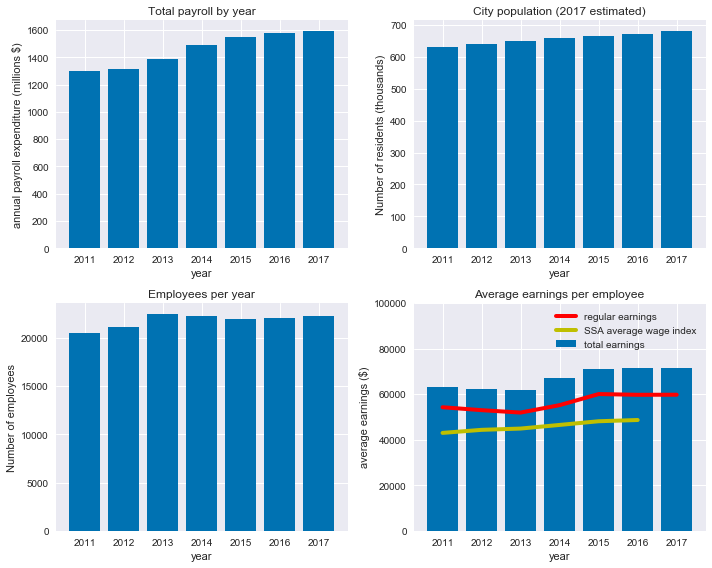

In [21]:
# total payroll by year
total_payroll = earnings.groupby(earnings['year'])[['regular', 'total', 'name']]\
                        .agg({'regular': np.sum, 'total': np.sum, 'name': 'count'})\
                        .reset_index()\
                        .set_index('year')
total_payroll['epc'] = total_payroll['total'] / total_payroll['name'] # average total earnings per capita
total_payroll['rpc'] = total_payroll['regular'] / total_payroll['name'] # average regular earnings per capita
total_payroll = total_payroll.reset_index()

""" 
Average wage index (AWI) for the United States
Source: https://www.ssa.gov/oact/cola/awidevelop.html
"""
total_payroll['awi'] = pd.Series([42979.61, 44321.67, 44888.16, 46481.52, 48098.63, 48642.15]) # AWI, years 2011-2016

"""
City of Boston population estimates
https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045216
2017 data is extrapolated from 2011-2016 data
"""

year_actual, pop_actual = np.array([2011, 2012, 2013, 2014, 2015, 2016]), \
                        np.array([630195, 641911, 651090, 659180, 665984, 673184])
f = interpolate.interp1d(year_actual, pop_actual, fill_value='extrapolate')
population = np.append(pop_actual, f(2017))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

x = total_payroll['year']

# Total payroll by year
ax1.bar(x, total_payroll['total']/1000000)
ax1.set_xlabel('year')
ax1.set_ylabel('annual payroll expenditure (millions $)')
ax1.set_title('Total payroll by year')

# City population
ax2.bar(x, population/1000)
ax2.set_xlabel('year')
ax2.set_ylabel('Number of residents (thousands)')
ax2.set_title('City population (2017 estimated)')

# Employees per year
ax3.bar(x, total_payroll['name'])
ax3.set_xlabel('year')
ax3.set_ylabel('Number of employees')
ax3.set_title('Employees per year')

# Average earnings per employee
ax4.bar(x, total_payroll['epc'])
ax4.plot(x, total_payroll['rpc'], alpha=1, color='r', linewidth=4)
ax4.plot(x, total_payroll['awi'], color='y', linewidth=4)
ax4.set_xlabel('year')
ax4.set_ylabel('average earnings ($)')
ax4.set_title('Average earnings per employee')
ax4.legend(['regular earnings', 'SSA average wage index', 'total earnings'])
ax4.set_ylim(0, 100000)

plt.tight_layout()
plt.show()

The plots above show that the rate of payroll growth is slowing in the past few years. The number of employees has not grown since 2013 despite a growing population and the average earnings per employee are nearly stagnant since 2015.

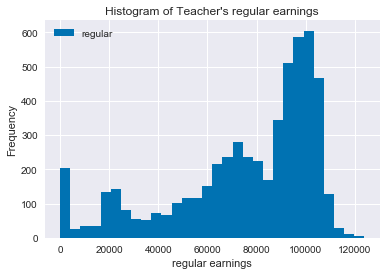

In [22]:
teachers = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Teacher')][['regular', 'department']]
teachers.plot(kind='hist', bins=30, title='Histogram of Teacher\'s regular earnings')
plt.xlabel('regular earnings')
plt.show()

Three modes are visible in the histogram plot. The first at around \$20,000 could be due to part time work, new hires, retirees, etc. The third at around \$100,000 is what is generally considered a teacher's salary in Boston. The second between \$60,000 and \$80,000 is worth looking into. The chart below suggests that the title "Teacher" may have been inappropriately given to 

In [23]:
# separate out the employees from the second mode from $60-85K
teachers70 = earnings[(earnings['year'] == 2017) \
                      & (earnings['title_clean'] == 'Teacher') \
                      & (earnings['regular'] > 60000) \
                      & (earnings['regular'] < 85000)] \
                      .groupby('department')\
                     [['regular', 'department']]\
                      .agg([np.median, np.size])\
                    .reset_index()
teachers70.columns = ['department', 'median', 'employees']
teachers70 = teachers70.sort_values(by='employees', ascending=False)[:20]
    
# for comparison: departments by size:
bps_depts = earnings[(earnings['year'] == 2017) \
                      & (earnings['title_clean'] == 'Teacher')] \
                     .groupby('department')\
                     ['name']\
                     .agg(np.size)\
            .reset_index()
            
bps_depts.columns = ['department', 'total_employees']

teachers_merged = pd.merge(teachers70, bps_depts, how='left', on='department')
                      
print(teachers_merged)

                       department     median  employees  total_employees
0           BPS Special Education  72661.470       49.0              281
1           BPS Madison Park High  68602.550       41.0              111
2            Henderson Elementary  72341.440       30.0              100
3            BPS East Boston High  72406.540       27.0              117
4                    Umana Middle  72070.050       27.0               85
5             Young Achievers K-8  75376.940       26.0               48
6                BPS Boston Latin  74684.540       26.0              130
7   BPS Orchard Gardens K-8 Pilot  73143.820       24.0               79
8             Tech Boston Academy  73078.370       23.0               76
9           UP Academy Dorchester  71056.910       22.0               80
10            BPS O'Bryant School  73334.800       22.0               92
11           BPS Mckay Elementary  70927.850       22.0               63
12      BPS Blackstone Elementary  71139.025       

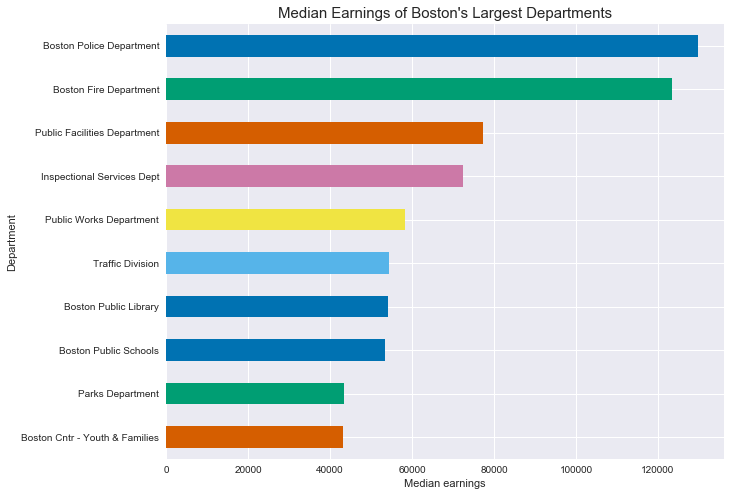

In [24]:
# Median earnings by department for 2017. Small departments are excluded for better statistics.

large_depts = pd.pivot_table(earnings[earnings.year==2017], values='total', aggfunc=[np.size, np.median], index='dept_clean')
large_depts = large_depts[large_depts[('size', 'total')] > 200] \
              .sort_values([('median', 'total')], ascending=False)[:15]

# for later use
large_depts_list = large_depts.index 

large_depts.columns = large_depts.columns.droplevel(1)
large_depts = large_depts['median']

fig = plt.figure(figsize=(10, 8))                 
large_depts.plot.barh().invert_yaxis()

_ = plt.title('Median Earnings of Boston\'s Largest Departments', fontsize=15)
_ = plt.ylabel('Department')
_ = plt.xlabel('Median earnings')
_ = plt.rc('ytick', labelsize=12)
_ = plt.rc('axes', labelsize=12)

plt.show()

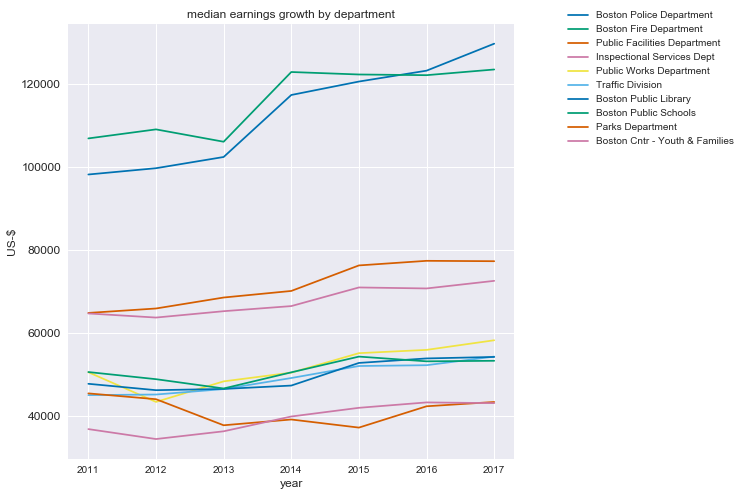

In [25]:
# plot earnings growth by department
ld = pd.pivot_table(earnings, index='dept_clean', columns='year', values=['total'], aggfunc=np.median)
ld.columns = ld.columns.droplevel()
ld = ld.loc[large_depts_list].T # filter based on list above

fig, ax = plt.subplots(figsize=(8,8))
ld.plot(ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title('median earnings growth by department')
ax.set_ylabel('US-$')
ax.set_xlabel('year')
# ax.set_yscale('log')

# cmap = plt.cm.hot
# rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(ld.columns))))

plt.show()

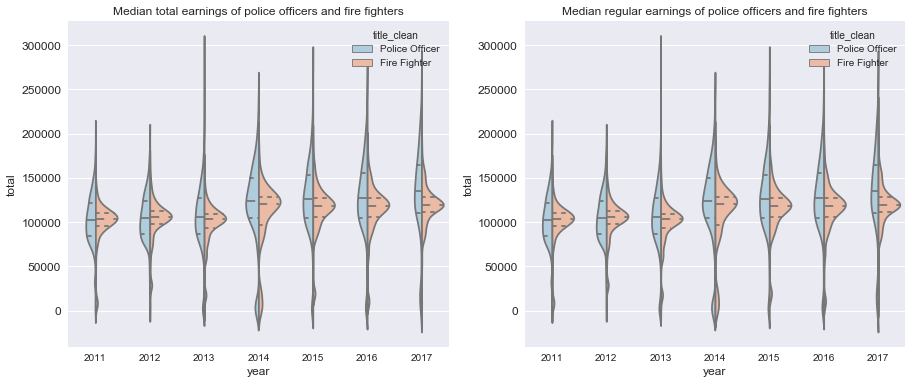

In [26]:
# fire fighters vs. police officers

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.set_title('Median total earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax1,
              inner='quartile', palette='RdBu_r')
ax2.set_title('Median regular earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax2,
              inner='quartile', palette='RdBu_r')
plt.show()

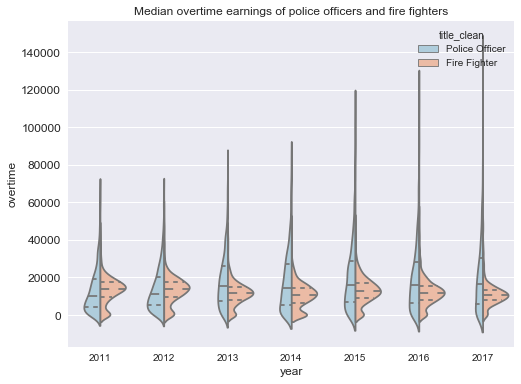

In [27]:
# fire fighters vs. police officers: Overtime

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax= plt.subplots(figsize=(8, 6))
ax.set_title('Median overtime earnings of police officers and fire fighters')
sns.violinplot(x='year', y='overtime', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

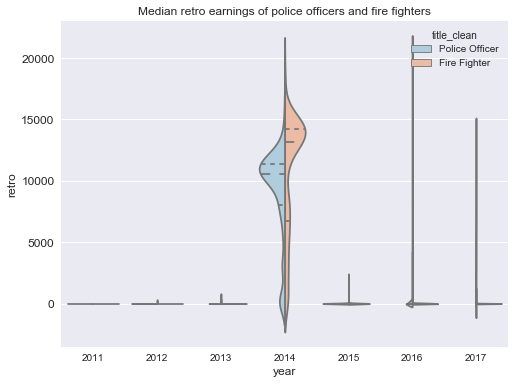

In [28]:
# What???

retro = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Median retro earnings of police officers and fire fighters')
sns.violinplot(x='year', y='retro', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

In [29]:
# retro earnings by year
retro_by_year = pd.pivot_table(earnings[earnings.retro != 0], columns='year', values='retro', index='dept_clean', aggfunc=[np.size, np.sum]).agg(np.sum)
print(retro_by_year)

      year
size  2011          30.00
      2012        2618.00
      2013       11948.00
      2014        4576.00
      2015          55.00
      2016         416.00
      2017        3256.00
sum   2011       84759.61
      2012      773973.86
      2013     8517434.02
      2014    47543988.05
      2015      110839.80
      2016    21247222.78
      2017     8864639.19
dtype: float64


In [30]:
# by dept
retro_by_dept = pd.pivot_table(earnings[(earnings.year == 2014)], values='retro', index='dept_clean', aggfunc=np.sum).sort_values(by='retro', ascending=False)
print(retro_by_dept[:10])

                                      retro
dept_clean                                 
Boston Police Department        25869366.20
Boston Fire Department          20414400.84
Boston Public Schools             773256.23
Boston Public Library             429864.57
Inspectional Services Dept         55438.08
Traffic Division                     874.04
Public Works Department              370.47
Auditing Department                  232.28
Dpt of Innovation & Technology       108.80
Public Facilities Department          76.54


In [31]:
# by title
retro_by_title = earnings[(earnings.year == 2014) \
                          & (earnings.dept_clean.isin(['Boston Police Department', \
                                                        'Boston Fire Department']))]\
                        .groupby('title_clean')\
                        ['retro']\
                        .agg(np.sum)\
                        .sort_values(ascending=False)
print(retro_by_title[:10])


title_clean
Police Officer         14937410.50
Fire Fighter           12972714.44
Police Sergeant         7027087.70
Fire Lieutenant         3442900.34
Police Lieutenant       2354503.79
Fire Captain            1307054.20
District Fire Chief     1098565.69
Police Captain           858703.64
Police Detective         368960.06
Dep Fire Chief           365344.38
Name: retro, dtype: float64


In [32]:
# by name 2016
retro_by_name = earnings.loc[(earnings.year == 2016) & (earnings.title == 'Police Detective')]\
                    [['name', 'regular', 'retro']]\
                    .sort_values(by='retro', ascending=False)
print(retro_by_name[:20])

                        name   regular      retro
110366         Brown,Gregory  97892.80  134476.33
126067           Ruiz,Melvin  99772.94  130420.43
123969        Painten,Paul A  92514.73  115642.68
123867    O'Sullivan,David M  98732.94  112780.19
122184         Mills,Vance C  93675.06  109967.56
128360    Tierney,Matthew M.   2862.18  107585.36
130272        Zingg,Robert M  97455.29  107368.53
112789     Cummings,Joshua O  96148.65  103432.55
117367            Herron,Tod  92514.73  102964.44
113908        Doogan,Kevin M  92514.73  102310.46
129534      Whalen,Richard L  72186.81  102255.55
119144         King,Joseph S  85387.59  101540.42
118580      Josey,Windell C.  92514.73  100296.36
115423     Fratalia,Robert A  96988.02   98878.64
108309    Acloque,Jean Moise  99361.13   98309.68
120483       MacIsaac,Paul A  92514.73   97629.64
109786        Blair,Steven F  92514.73   96211.51
110077  Boyle,Christopher R.  90180.85   96175.40
128315      Thompson,James M  92077.30   95827.00


In [33]:
greg = earnings.loc[earnings.name == 'Brown,Gregory']
greg

,name,department,title,regular,retro,other,overtime,injured,detail,quinn,total,zip,year,dept_clean,title_clean
3953,"Brown,Gregory",Boston Police Department,Police Detective,76091.03,0.00,12010.00,77234.02,0.0,0.0,0.0,165335.05,02301,2011,Boston Police Department,Police Detective
26466,"Brown,Gregory",Boston Police Department,Police Detective,75651.04,0.00,11804.00,72755.78,0.0,8111.0,0.0,168321.82,02301,2012,Boston Police Department,Police Detective
43777,"Brown,Gregory",Boston Police Department,Police Detective,75651.03,0.00,11804.00,86943.67,0.0,6126.0,0.0,180524.70,02301,2013,Boston Police Department,Police Detective
81594,"Brown,Gregory",Boston Police Department,Police Detective,75651.03,0.00,11804.00,82928.54,0.0,11194.0,0.0,181577.57,02301,2014,Boston Police Department,Police Detective
88424,"Brown,Gregory",Boston Police Department,Police Detective,77020.28,0.00,11754.00,98618.64,0.0,11040.0,0.0,198432.92,02301,2015,Boston Police Department,Police Detective
110366,"Brown,Gregory",Boston Police Department,Police Detective,97892.80,134476.33,15752.49,87511.88,0.0,16192.0,0.0,351825.50,02301,2016,Boston Police Department,Police Detective
130902,"Brown,Gregory",Boston Police Department,Police Detective,103987.91,5526.34,15752.48,122364.06,0.0,2024.0,0.0,249654.79,02301,2017,Boston Police Department,Police Detective


In [34]:
"""
1. Obtain latitude and longitude data for US zip codes from
https://www.census.gov/geo/maps-data/data/gazetteer2017.html

2. Count number of employees by zip code

3. Perform inner merge to get complete sets 

4. Filter Boston zip codes from suburban zip codes.
"""
zll = pd.read_csv('2017_Gaz_zcta_national.txt', sep='\t', encoding = "ISO-8859-1", usecols=[0, 5, 6], names=['zip', 'lat', 'long'], header=0, dtype={'zip': object})

zip_count = earnings[earnings.year == 2017].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})

zip_df = pd.merge(zip_count, zll, on='zip', how='inner')

# Read in Boston zipcode list
boston = pd.read_csv('boston-zipcodes.csv', names=['zip'], header=None, dtype={'zip': object})

# US population by zipcode (2010 Census)
population = pd.read_csv('2010+Census+Population+By+Zipcode+(ZCTA).csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['zip', 'pop'], header=0, dtype={'zip': object})
population = population.groupby('zip')['pop'].agg(np.sum).reset_index()

# generate various zip code maps
boston = pd.merge(zip_df, boston, on='zip', how='inner')
suburbs = zip_df[~zip_df['zip'].isin(boston.zip)]

# by title
teachers = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Teacher')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'teachers'})
policemen = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Police Officer')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'police_officers'})
firemen = earnings[(earnings['year'] == 2017) & (earnings['title_clean'] == 'Fire Fighter')].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'fire_fighters'})
titles = teachers.merge(policemen, on='zip', how='outer')\
                .merge(firemen, on='zip', how='outer')\
                .merge(zll, on='zip', how='left')\
                .merge(population, on='zip', how='left')\
                .fillna(0)
titles = titles[titles['pop'] >= 1] # avoid div by zero error (and nonsense data)
titles['teachers_pc'] = titles['teachers'] / titles['pop'] * 100
                
# by income level 
rich = earnings[(earnings['year'] == 2017) & (earnings['total'] >= 81500)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
poor = earnings[(earnings['year'] == 2017) & (earnings['total'] < 81500) & (earnings['total'] >= 19917)].groupby('zip')['name'].agg(np.size).reset_index().rename(columns={'name': 'employees'})
rich = rich.merge(zll, on='zip', how='left').merge(population, on='zip', how='left')
poor = poor.merge(zll, on='zip', how='left').merge(population, on='zip', how='left')
rich = rich[rich['pop'] >= 1] # avoid div by zero error (and nonsense data)
poor = poor[poor['pop'] >= 1] # avoid div by zero error (and nonsense data)
rich['emp'] = rich['employees'] / rich['pop'] * 100
poor['emp'] = poor['employees'] / poor['pop'] * 100

# normalize "rich" employee count to match "poor":
print(rich.employees.sum(), poor.employees.sum())
# titles[titles['teachers_pc'] >1]

rich.head()

9013 9025


,zip,employees,lat,long,pop,emp
0,01057,1,42.093596,-72.321494,8534.0,0.011718
1,01201,1,42.448236,-73.273727,46504.0,0.002150
2,01420,2,42.584925,-71.816862,40337.0,0.004958
3,01431,1,42.676293,-71.832523,3074.0,0.032531
4,01432,1,42.564663,-71.567298,7089.0,0.014106


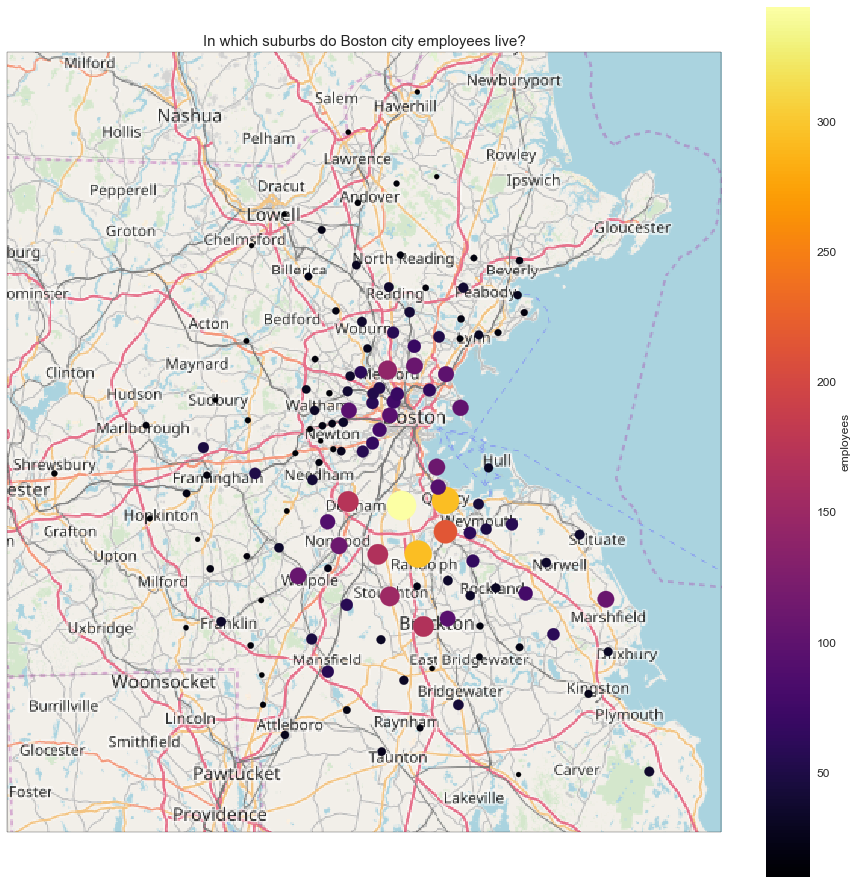

In [35]:
# map image from open street maps
osm_tiles = OSM()

fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# suburban zip codes with at least 10 employees
suburbs_min10 = suburbs[suburbs['employees'] > 9]
suburbs_min10.plot('long','lat', kind='scatter', marker='.', s=suburbs_min10['employees'].values * 10, c='employees', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which suburbs do Boston city employees live?', fontsize=15)
plt.savefig('suburbs.png')
plt.show()

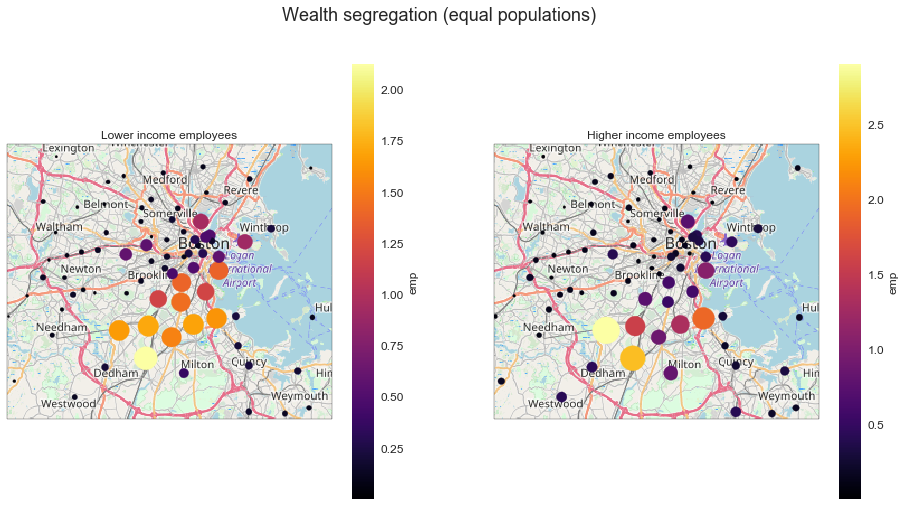

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': osm_tiles.crs}, figsize=(16, 8))

# define map range
img_extent = (-71.3, -70.9, 42.45, 42.2)
ax1.set_extent(img_extent, ccrs.PlateCarree())
ax2.set_extent(img_extent, ccrs.PlateCarree())

# # add map image, state lines
ax1.add_image(osm_tiles, 10)
ax2.add_image(osm_tiles, 10)

poor.plot('long','lat', kind='scatter', marker='.', s=poor['emp'].values*1000, c='emp', cmap=plt.cm.inferno, ax=ax1, transform=ccrs.PlateCarree())
rich.plot('long','lat', kind='scatter', marker='.', s=rich['emp'].values*1000, c='emp', cmap=plt.cm.inferno, ax=ax2, transform=ccrs.PlateCarree())

ax1.set_title('Lower income employees', fontsize=12)
ax2.set_title('Higher income employees', fontsize=12)
plt.suptitle('Wealth segregation (equal populations)', fontsize=18)
plt.show()


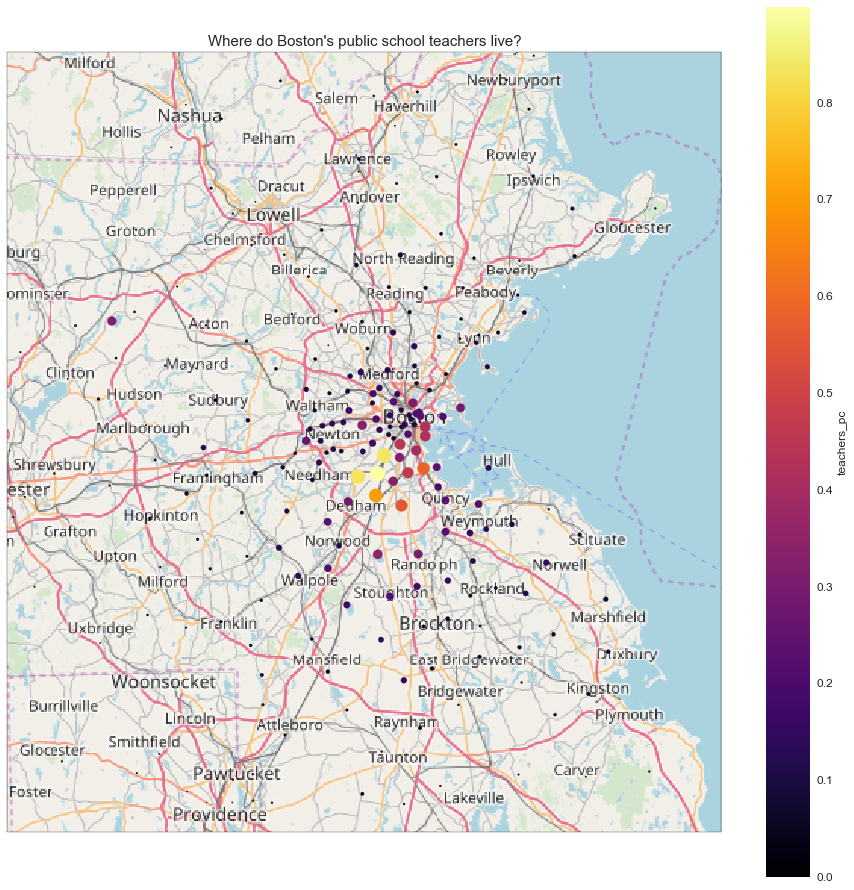

In [37]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range
img_extent = (-71.8, -70.5, 42.85, 41.8)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image, state lines
ax.add_image(osm_tiles, 9)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

titles.plot('long','lat', kind='scatter', marker='.', s=titles['teachers_pc'].values * 1000, c='teachers_pc', cmap=plt.cm.inferno, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('Where do Boston\'s public school teachers live?', fontsize=15)

plt.show()

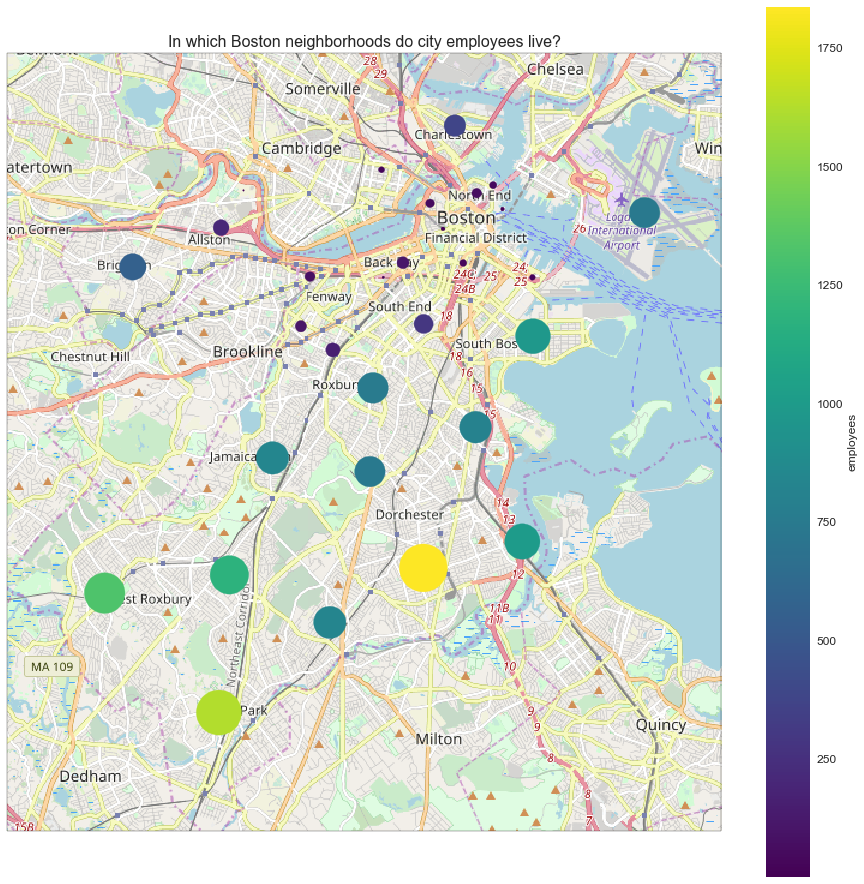

In [38]:
fig = plt.figure(figsize=(16, 16))
ax = plt.axes(projection=osm_tiles.crs)

# define map range (city of Boston)
img_extent = (-71.19, -70.985, 42.395, 42.23)
ax.set_extent(img_extent, ccrs.PlateCarree())

# add map image
ax.add_image(osm_tiles, 12)

# boston data
boston.plot('long','lat', kind='scatter', marker='.', s=boston['employees'].values*5, c='employees', cmap=plt.cm.viridis, ax=ax, transform=ccrs.PlateCarree())

ax.set_title('In which Boston neighborhoods do city employees live?', fontsize=16)

plt.show()

In [39]:
"""
Adjusted Gross Income (AGI) by zip code

Available for years 1998 through 2015
from:
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi

data:
https://www.irs.gov/pub/irs-soi/15zpallagi.csv
data documentation:
https://www.irs.gov/pub/irs-soi/15zpdoc.doc

"""
agi = pd.read_csv('15zpallagi.csv', encoding = "ISO-8859-1", usecols=['STATE', 'zipcode', 'agi_stub', 'N1', 'NUMDEP', 'A00100', 'A00200', 'A02650'], dtype={'zipcode': object})
print(agi.head())
agi['sum'] = agi['N1'] *  agi['A00100']
agi = agi.groupby('zipcode').agg(np.sum).reset_index()

agi['agi'] = agi['sum'] / agi['N1']

  STATE zipcode  agi_stub        N1    NUMDEP      A00100      A02650      A00200
0    AL   00000         1  836320.0  525260.0  10855656.0  11036309.0   8646476.0
1    AL   00000         2  494830.0  372110.0  17781527.0  17960153.0  14643298.0
2    AL   00000         3  261250.0  183750.0  16060852.0  16216787.0  12392305.0
3    AL   00000         4  166690.0  132360.0  14458583.0  14588959.0  10918456.0
4    AL   00000         5  212660.0  192840.0  28682367.0  28985528.0  21190845.0


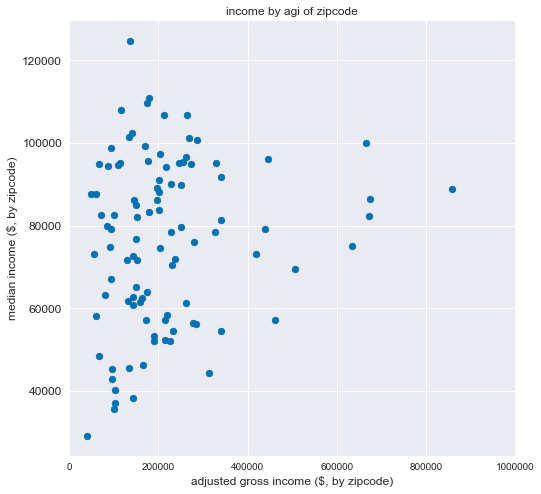

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
zipcode = earnings.groupby('zip')['total'].agg([np.size, np.median]).sort_values(by='size', ascending=False).reset_index()[:100]
zip_agi = pd.merge(zipcode, agi, left_on='zip', right_on='zipcode', how='left')
ax.scatter(zip_agi['agi'], zip_agi['median'])
ax.set_xlim(0, 1000000)
ax.set_xlabel('adjusted gross income ($, by zipcode)')
ax.set_ylabel('median income ($, by zipcode)')
ax.set_title('income by agi of zipcode')
# plt.xticks(rotation='vertical')
# ax.locator_params(nbins=25, axis='x')
plt.show()

## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2017?

67 % of city employees live in Boston (2017).


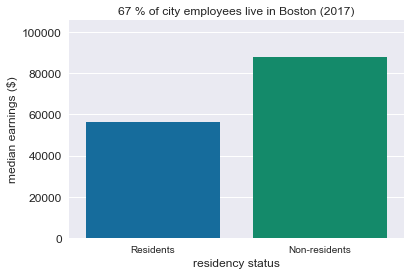

In [41]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
outzips = earnings.loc[(~earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100
print(int(residents), '% of city employees live in Boston (2017).')

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'residency status': ['Residents', 'Non-residents'], 'median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
plt.title('%s %% of city employees live in Boston (2017)'%(int(residents)))
sns.barplot(x='residency status', y='median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()